# 라이브러리 불러오기

In [13]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import matplotlib.pyplot as plt

# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [3]:
train_data = pd.read_csv('../../data/data/train.csv')
test_data = pd.read_csv('../../data/data/test.csv')
sample_submission = pd.read_csv('../../data/data/sample_submission.csv')

# 데이터 EDA 수행하기

In [4]:
print("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)
# print("train data 상단 5개 정보 확인 : ", train_data.head())
# print("test data 상단 5개 정보 확인 : ", test_data.head())
# print("sample_submission 상단 5개 정보 확인 : ", sample_submission.head())
print("train data 변수 요약 정보 확인 : \n", train_data.describe())
print("test data 변수 요약 정보 확인 : \n", test_data.describe())

train, test_data, sample_submission shape :  (1801228, 11) (150172, 10) (150172, 2)
train data 변수 요약 정보 확인 : 
               index       area_m2  contract_year_month  contract_day  \
count  1.801228e+06  1.801228e+06         1.801228e+06  1.801228e+06   
mean   9.006135e+05  7.518833e+01         2.021331e+05  1.589943e+01   
std    5.199699e+05  2.552632e+01         1.352815e+02  8.625998e+00   
min    0.000000e+00  1.032150e+01         2.019040e+05  1.000000e+00   
25%    4.503068e+05  5.975000e+01         2.020080e+05  9.000000e+00   
50%    9.006135e+05  7.715000e+01         2.021110e+05  1.600000e+01   
75%    1.350920e+06  8.496000e+01         2.022120e+05  2.300000e+01   
max    1.801227e+06  3.173600e+02         2.023120e+05  3.100000e+01   

       contract_type         floor    built_year      latitude     longitude  \
count   1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06   
mean    1.203805e+00  1.005197e+01  2.004199e+03  3.747721e+01  1.269662e+02   


# 대회에 필요한 데이터만 활용하기

In [5]:
columns_needed = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'deposit']
columns_needed_test = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude']
train_data = train_data[columns_needed]
test_data = test_data[columns_needed_test]

# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [6]:
holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

# 학습 데이터와 정답 데이터 분리

In [7]:
X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

# LightGBM 모델 훈련

In [29]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
# lgb_model.fit(X_train, y_train)

# batch로 나눠서 학습
batch_num = 10
batch_size = len(X_train) // batch_num
for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    # lgb_model.fit(X_batch, y_batch)
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 159436, number of used features: 6
[LightGBM] [Info] Start training from score 26272.222146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 159436, number of used features: 6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

# Holdout 데이터셋에 대한 성능 확인

In [30]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

Holdout 데이터셋 성능:
LightGBM MAE: 12430.64


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

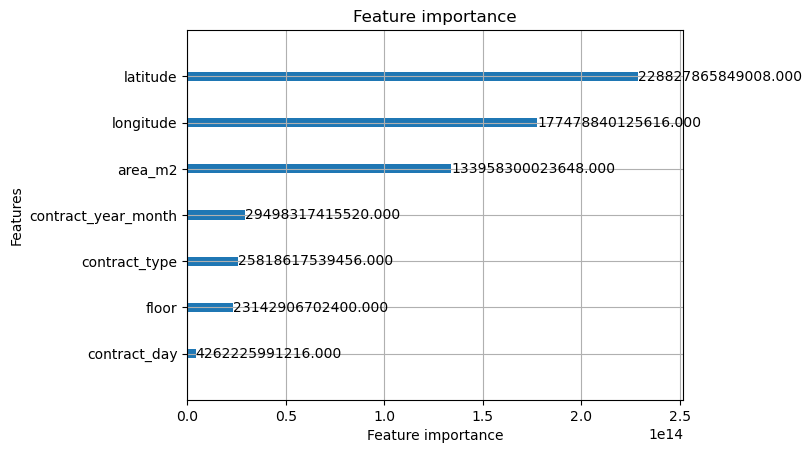

In [31]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)


(0.0, 80.0)

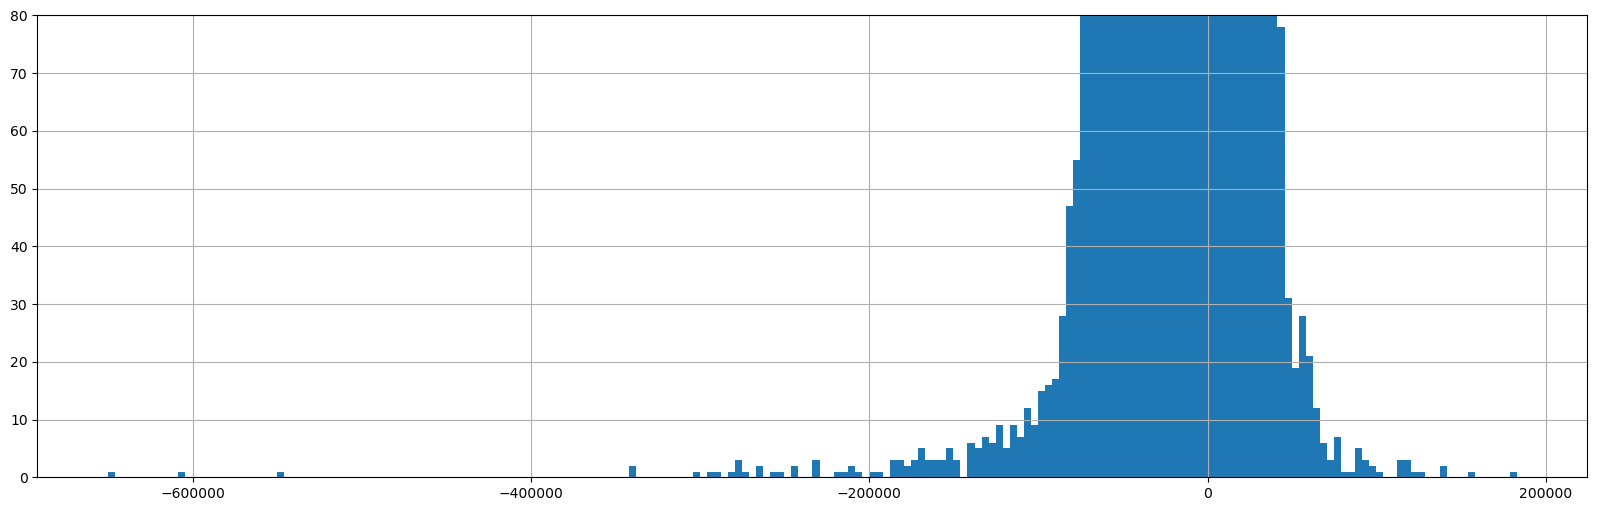

In [33]:
pred_df = pd.DataFrame({'pred': lgb_holdout_pred, 'target': y_holdout})
pred_df["diff"] = pred_df["pred"] - pred_df["target"]
pred_df["diff"].hist(bins=200, figsize=(20, 6))
plt.ylim(0, 80)
# plt.xlim(-200000, 200000)

# Sample Submission 제출하기

In [27]:
lgb_test_pred = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred
sample_submission.to_csv(f"output_{datetime.datetime.now().replace(second=0, microsecond=0)}.csv", index=False, encoding='utf-8-sig')